# **Preprocesamiento Avance 1 Proyecto**

#### Integrantes
- *Santiago Cassiano Rozo*
- *Fabian Camilo Castro Lozano*
- *David Jose Leon Aroca*

## Importar las librerias que se utilizaran a lo largo del preprocesamiento

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from scipy.stats import chi2
from sklearn.preprocessing import KBinsDiscretizer
from mpl_toolkits import mplot3d
import math

## Importar y mostrar el conjunto de datos original

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
bank_df = pd.read_csv("/content/gdrive/Shareddrives/Minería de datos/Proyecto/I. Dataset/bank-full.csv", sep=";")
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Limpieza del dataset



### Datos faltantes
Cinco campos tienen datos faltantes:

1. Contact (categórica)
2. Pdays (numérica)
3. Poutcome (categórica)
4. Job (categórica)
5. Education (categórica)

Reemplazaremos los datos faltantes en contact, job, education y poutcome por la moda de dicho atributo

In [ ]:
bank_df.loc[bank_df["contact"] == "unknown", ["contact"]]  = (bank_df.loc[bank_df["contact"] != "unknown", ["contact"]].mode())["contact"][0]
bank_df.loc[bank_df["poutcome"] == "unknown", ["poutcome"]]  = (bank_df.loc[ bank_df["poutcome"] != "unknown", ["poutcome"]].mode())["poutcome"][0]
bank_df.loc[bank_df["job"] == "unknown", ["job"]]  = (bank_df.loc[ bank_df["job"] != "unknown", ["job"]].mode())["job"][0]
bank_df.loc[bank_df["education"] == "unknown", ["education"]]  = (bank_df.loc[ bank_df["education"] != "unknown", ["education"]].mode())["education"][0]

In [ ]:
print(bank_df["contact"].value_counts())
print("_____________________")
print(bank_df["poutcome"].value_counts())
print("_____________________")
print(bank_df["job"].value_counts())
print("_____________________")
print(bank_df["education"].value_counts())

cellular     42305
telephone     2906
Name: contact, dtype: int64
_____________________
failure    41860
other       1840
success     1511
Name: poutcome, dtype: int64
_____________________
blue-collar      10020
management        9458
technician        7597
admin.            5171
services          4154
retired           2264
self-employed     1579
entrepreneur      1487
unemployed        1303
housemaid         1240
student            938
Name: job, dtype: int64
_____________________
secondary    25059
tertiary     13301
primary       6851
Name: education, dtype: int64


Para pdays, se considerarán dos opciones, la primera es reemplazar los valores de -1 por la media, tras eliminar los datos outliers en dicho atributo (usando 3 desviaciones estándar). La segunda es reemplazar los valores de -1 por la mediana


In [ ]:
pdays_replace_by = 0

pdays_df = bank_df.loc[bank_df["pdays"] != -1 , ["pdays"]].copy()
pdays_df_mean = pdays_df.mean()
pdays_df_std = pdays_df.std(ddof=1)

is_outlier = lambda x, mean , std: np.abs(x-mean) < 3 * std
is_outlier_v = np.vectorize(is_outlier)

pdays_df_outliers = is_outlier_v(pdays_df["pdays"], pdays_df_mean.pdays , pdays_df_std.pdays)
pdays_df = pdays_df.loc[pdays_df_outliers, ["pdays"]]

pdays_df_mean = pdays_df.mean().pdays
pdays_median = bank_df.loc[bank_df["pdays"] != -1 , ["pdays"]].median().pdays
print(f"Media recalculada: {pdays_df_mean}")
print(f"Mediana : {pdays_median}")


Media recalculada: 220.91093216203026
Mediana : 194.0


Como se observa la media sigue estando casi 30 días por arriba de la mediana. Puede ser que algún dato no atípico de pdays siga arrastrando la media hacia arriba. Por este motivo se usará la mediana para el reemplazo

In [ ]:
# Reemplazando los atributos faltantes por la nueva media (descomentar)
# bank_df.loc[bank_df["pdays"] == -1 , ["pdays"]] = pdays_df_mean.pdays

# Reemplazando por la mediana
bank_df.loc[bank_df["pdays"] == -1 , ["pdays"]] = pdays_median

In [ ]:
print(bank_df["pdays"].value_counts())

194    36969
182      167
92       147
91       126
183      126
       ...  
404        1
32         1
551        1
670        1
530        1
Name: pdays, Length: 558, dtype: int64


### Detección y eliminación de outliers

Usando la distancia de Mahalanobis

In [ ]:
X = np.array(bank_df.loc[:,["age", "balance", "duration", "campaign" , "pdays", "previous"]])
mu = np.mean(X, axis=0)
S = np.cov(X, rowvar = False)
S_inverse = np.linalg.inv(S)

def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

print(is_pos_def(S) , is_pos_def(S_inverse))

mahalanobis_distance = lambda x, mu , S_inverse: scp.spatial.distance.mahalanobis(x, mu , S_inverse)

mahalanobis_distances = []
i = 1
for entry in X:
  md = mahalanobis_distance(entry,mu,S_inverse)
  mahalanobis_distances.append(md)

# Umbral
threshold = chi2.ppf((1-0.05), df=X.shape[1])

mahalanobis_distances = np.array(mahalanobis_distances)
outliers_md = np.power(mahalanobis_distances,2) < threshold

bank_df = bank_df.loc[outliers_md, :]


True True


### Resultado de la limpieza

Se observa que con la limpieza de outliers se eliminaron 4121 registros, dejando un total de 41090 registros en el dataset.

In [ ]:
bank_df.shape

(41090, 17)

Se reindexa el dataset y se muestran como quedo tras la limpieza.

In [ ]:
bank_df = bank_df.reset_index(drop=True)
bank_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,194,0,failure,no
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,194,0,failure,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,194,0,failure,no
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,may,92,1,194,0,failure,no
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,may,198,1,194,0,failure,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41085,23,student,single,tertiary,no,113,no,no,cellular,17,nov,266,1,194,0,failure,yes
41086,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,386,2,194,0,failure,yes
41087,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,194,0,failure,yes
41088,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,194,0,failure,yes


Aqui se hace un llamado a la funcion describe() para conocer algunas medidas de los atributos numericos del dataset limpiado.

In [167]:
bank_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,41090.000000,41090.000000,41090.000000,41090.000000,41090.000000,41090.000000,41090.000000
mean,40.633950,1077.663762,15.755196,236.353371,2.464298,197.342419,0.349209
std,10.114831,1737.374394,8.306172,193.646855,1.977705,36.374087,1.005016
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,30.000000,0.000000
25%,33.000000,66.000000,8.000000,104.000000,1.000000,194.000000,0.000000
50%,39.000000,425.000000,16.000000,178.000000,2.000000,194.000000,0.000000
75%,48.000000,1331.000000,21.000000,306.000000,3.000000,194.000000,0.000000
max,78.000000,11766.000000,31.000000,1156.000000,13.000000,374.000000,8.000000


Almacenamos el dataset limpiado en nuestra unidad de google drive

In [168]:
bank_df.to_csv('/content/gdrive/Shareddrives/Minería de datos/Proyecto/I. Dataset/dataset_limpiado.csv')

## Creacion de un dataset completamente numerico

Creamos una copia del dataset para crear el nuevo dataset numerico

In [ ]:
df_numerico = bank_df.copy()

El atributo "job" es categorico y para volverlo numerico se utilizara la tecnica one-hot encoding. Este atributo podia tomar 11 valores distintos, entonces la columna job se remplazara por 11 columnas nuevas, una para cada valor que podia tomar job.

In [ ]:
# Se obtienen las nuevas columnas para cada valor de job
columnas_extra = pd.get_dummies(df_numerico.job)

# Se almacenan las nuevas columnas en el dataframe
df_numerico = pd.concat([df_numerico, columnas_extra], axis='columns')

# Se elimina la columna job en el dataframe numerico
df_numerico.drop(columns=['job'], inplace=True)

El atributo "marital" es categorico y para volverlo numerico se utilizara la tecnica one-hot encoding. Este atributo podia tomar 3 valores distintos. Entonces la columna marital se remplazara por 3 columnas nuevas, una para cada valor que podia tomar marital.

In [ ]:
# Se obtienen las nuevas columnas para cada valor de marital
columnas_extra = pd.get_dummies(df_numerico.marital)

# Se almacenan las nuevas columnas en el dataframe
df_numerico = pd.concat([df_numerico, columnas_extra], axis='columns')

# Se elimina la columna marital en el dataframe numerico
df_numerico.drop(columns=['marital'], inplace=True)

El atributo "education" es categorico y para volverlo numerico se utilizara la tecnica de codificación de etiquetas ya que es ordinal.

*   El valor primary se convertira en 1
*   El valor secondary se convertira en 2
*   El valor tertiary se convertira en 3

In [ ]:
#Se remplazan los valores de la columna por su numero equivalente
df_numerico["education"].replace(to_replace="primary", value = 1, inplace=True)
df_numerico["education"].replace(to_replace="secondary", value = 2, inplace=True)
df_numerico["education"].replace(to_replace="tertiary", value = 3, inplace=True)

El atributo default es categorico y solo puede tomar 2 valores. Para volverlo numerico se remplazará el valor "no" por 0 y el valor "yes" por 1.

In [ ]:
# Remplazar los valores en la columna default
df_numerico['default'].replace(['no', 'yes'],[0, 1], inplace=True)

El atributo housing es categorico y solo puede tomar 2 valores. Para volverlo numerico se remplazará el valor "no" por 0 y el valor "yes" por 1.

In [ ]:
# Remplazar los valores en la columna housing
df_numerico['housing'].replace(['no', 'yes'],[0, 1], inplace=True)

El atributo loan es categorico y solo puede tomar 2 valores. Para volverlo numerico se remplazará el valor "no" por 0 y el valor "yes" por 1.

In [ ]:
# Remplazar los valores en la columna loan
df_numerico['loan'].replace(['no', 'yes'],[0, 1], inplace=True)

El atributo contact es categorico y solo puede tomar 2 valores. Para volverlo numerico se remplazará el valor "cellular" por 0 y el valor "telephone" por 1.

In [ ]:
# Remplazar los valores en la columna contact
df_numerico['contact'].replace(['cellular', 'telephone'],[0, 1], inplace=True)

El atributo month es categorico y para volverlo numerico se utilizara la tecnica de codificación de etiquetas ya que es ordinal.

*   El valor jan se convertira en 1
*   El valor feb se convertira en 2
*   El valor mar se convertira en 3
*   El valor apr se convertira en 4
*   El valor may se convertira en 5
*   El valor jun se convertira en 6
*   El valor jul se convertira en 7
*   El valor aug se convertira en 8
*   El valor sep se convertira en 9
*   El valor oct se convertira en 10
*   El valor nov se convertira en 11
*   El valor dec se convertira en 12


In [ ]:
# Remplazar los valores en la columna contact
df_numerico['month'].replace(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], inplace=True)

El atributo "poutcome" es categorico y para volverlo numerico se utilizara la tecnica one-hot encoding. Este atributo podia tomar 3 valores distintos, entonces la columna poutcome se remplazara por 3 columnas nuevas, una para cada valor que podia tomar poutcome.

In [ ]:
# Se obtienen las nuevas columnas para cada valor de poutcome
columnas_extra = pd.get_dummies(df_numerico.poutcome)

# Se almacenan las nuevas columnas en el dataframe
df_numerico = pd.concat([df_numerico, columnas_extra], axis='columns')

# Se elimina la columna poutcome en el dataframe numerico
df_numerico.drop(columns=['poutcome'], inplace=True)

El atributo "y" es categorico y solo puede tomar 2 valores. Para volverlo numerico se remplazará el valor "no" por 0 y el valor "yes" por 1.

In [ ]:
# Remplazar los valores en la columna y
df_numerico['y'].replace(['no', 'yes'],[0, 1], inplace=True)

Despues de todas las transformaciones hemos obtenido un dataset completamente numerico compuesto por 31 columnas distintas. El nuevo dataset se muestra a continuacion.

In [ ]:
df_numerico

,age,education,default,balance,housing,loan,contact,day,month,duration,...,services,student,technician,unemployed,divorced,married,single,failure,other,success
0,58,3,0,2143,1,0,0,5,5,261,...,0,0,0,0,0,1,0,1,0,0
1,44,2,0,29,1,0,0,5,5,151,...,0,0,1,0,0,0,1,1,0,0
2,33,2,0,2,1,1,0,5,5,76,...,0,0,0,0,0,1,0,1,0,0
3,47,2,0,1506,1,0,0,5,5,92,...,0,0,0,0,0,1,0,1,0,0
4,33,2,0,1,0,0,0,5,5,198,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41085,23,3,0,113,0,0,0,17,11,266,...,0,1,0,0,0,0,1,1,0,0
41086,25,2,0,505,0,1,0,17,11,386,...,0,0,1,0,0,0,1,1,0,0
41087,51,3,0,825,0,0,0,17,11,977,...,0,0,1,0,0,1,0,1,0,0
41088,71,1,0,1729,0,0,0,17,11,456,...,0,0,0,0,1,0,0,1,0,0


In [ ]:
df_numerico.to_csv('/content/gdrive/Shareddrives/Minería de datos/Proyecto/I. Dataset/numerico.csv')

##PCA sobre el dataset limpio

Calculando la matriz de covarianza, vector de medias y los eigenvalues de la matriz covarianza para aplicar el método PCA

In [ ]:
covariance_bank = np.cov(np.array(bank_df.loc[: , ["age", "balance", "duration", "campaign" , "pdays", "previous"]]).transpose(), ddof=1)
means_bank = np.mean(bank_df.loc[: , ["age", "balance", "duration", "campaign" , "pdays", "previous"]], axis=0)
eigen_val_vec = np.linalg.eig(covariance_bank)

Organizando los eigenvalues de mayor a menor y los eigenvectors de acuerdo a dicho orden.

In [ ]:
# Returns the indices that would sort an array.
idx = eigen_val_vec[0].argsort()[::-1]
eigenValues = eigen_val_vec[0][idx]
eigenVectors = eigen_val_vec[1][:,idx]

Analizar la proporción de la varianza (eigenvalues). Dividiendo la suma de los
primeros m eigenvalues por la suma de todos los eigenvalues

In [ ]:
# How many principal components
for m in range(1,len(eigenValues)):
    r = sum(eigenValues[0:m])/sum(eigenValues)
    print(m,r)
print(f"Orden de los atributos por mayor eigenvalue:\n{idx}")

1 0.9872735007868465
2 0.9995347882559391
3 0.9999653457589731
4 0.9999984079905864
5 0.9999996773497699
Orden de los atributos por mayor eigenvalue:
[0 1 2 3 4 5]


Así observamos que con dos componentes se puede alcanzar una valor de r del 99.95%. Calcularemos la proyección sobre ese espacio usando la librería de sklearn

In [ ]:
from sklearn.decomposition import PCA

numComponents = 2
pca = PCA(n_components=numComponents)
pca.fit(bank_df.loc[: , ["previous","age","balance","duration","campaign"]])

projected = pca.transform(bank_df.loc[: , ["previous","age","balance","duration","campaign"]])
projected = pd.DataFrame(projected,columns=['PC1','PC2'])
projected['y'] = bank_df["y"]
projected

,PC1,PC2,y
0,1065.393242,22.476906,no
1,-1048.831216,-83.249350,no
2,-1075.988153,-158.176149,no
3,428.048587,-145.223296,no
4,-1076.742791,-36.174611,no
...,...,...,...
41085,-964.611877,31.616921,yes
41086,-572.370301,150.824151,yes
41087,-251.167879,741.133636,yes
41088,651.793570,218.285447,yes


Graficaremos una muestra estratificada con un tamaño del 5% original para cada categoría

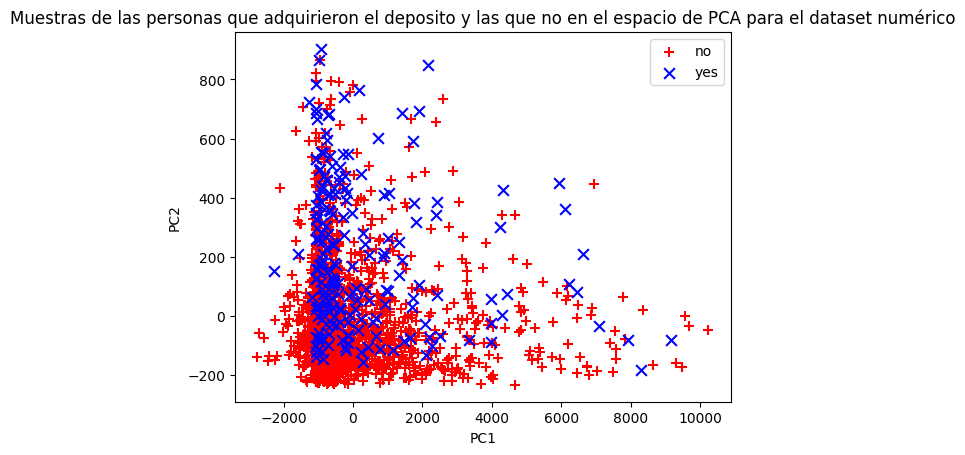

In [ ]:
colors = {'no':'r', 'yes':'b'}
markerTypes = {'no':'+', 'yes':'x'}

sample_subgroup_y = bank_df.groupby("y").get_group("yes").sample(frac=0.05)
sample_subgroup_n = bank_df.groupby("y").get_group("no").sample(frac=0.05)
sample = pd.concat([sample_subgroup_y,sample_subgroup_n])


for bank in markerTypes:
    if bank ==  "no":
      d_sample = projected.loc[sample_subgroup_n.index, :]
      plt.scatter(d_sample['PC1'],d_sample['PC2'],c=colors[bank],s=60,marker=markerTypes[bank] , label=bank)
    else:
      d_sample = projected.loc[sample_subgroup_y.index, :]
      plt.scatter(d_sample['PC1'],d_sample['PC2'],c=colors[bank],s=60,marker=markerTypes[bank] , label=bank)

    plt.title("Muestras de las personas que adquirieron el deposito y las que no en el espacio de PCA para el dataset numérico")
    plt.legend()
    plt.xlabel("PC1")
    plt.ylabel("PC2")

## Aplicando PCA al dataset numérico

Aplicando PCA de la forma en la que se aplicó en la sección anterior

In [ ]:
covariance_bank_n = np.cov(df_numerico.transpose(), ddof=1)
means_bank_n = np.mean(df_numerico, axis=0)
eigen_val_vec_n = np.linalg.eig(covariance_bank_n)

In [ ]:
# Returns the indices that would sort an array.
idx_n = eigen_val_vec_n[0].argsort()[::-1]
eigenValues_n = eigen_val_vec_n[0][idx_n]
eigenVectors_n = eigen_val_vec_n[1][:,idx_n]

In [ ]:
# How many principal components
for m in range(1,len(eigenValues_n)):
    r = sum(eigenValues_n[0:m])/sum(eigenValues_n)
    print(m,r)

print(f"Orden de los atributos por mayor eigenvalue:\n{idx}")

1 0.9872486043041236
2 0.9995096046241382
3 0.9999403237292918
4 0.9999734326733766
5 0.9999959117350155
6 0.9999976768668689
7 0.9999989123765506
8 0.9999992430921909
9 0.9999994153523352
10 0.9999995253300785
11 0.9999995994725117
12 0.9999996590802004
13 0.9999997064235564
14 0.999999750415056
15 0.9999997935999118
16 0.999999829786773
17 0.9999998612167473
18 0.9999998863837216
19 0.9999999040428702
20 0.9999999214962713
21 0.9999999382017679
22 0.999999949988486
23 0.9999999610759912
24 0.9999999707701285
25 0.9999999796973925
26 0.9999999879224029
27 0.9999999941372268
28 1.0
29 1.0
30 1.0
Orden de los atributos por mayor eigenvalue:
[0 1 2 3 4 5]


In [ ]:
(eigenValues_n[:5] - eigenValues[:5])/sum(eigenValues_n)

array([2.50915372e-08, 2.23604812e-08, 1.72470608e-07, 4.75470557e-08,
       2.12097345e-05])

Con dos componentes se alcanza un r del 99,95%

In [ ]:
numComponents = 2
pca = PCA(n_components=numComponents)
pca.fit(df_numerico)

projected_numeric = pca.transform(df_numerico)
projected_numeric = pd.DataFrame(projected_numeric,columns=['PC1','PC2'])
projected_numeric['y'] = df_numerico["y"]
projected_numeric

,PC1,PC2,y
0,1065.396139,22.496159,0
1,-1048.826099,-83.218260,0
2,-1075.983019,-158.144493,0
3,428.052117,-145.199434,0
4,-1076.737630,-36.143714,0
...,...,...,...
41085,-964.605172,31.631213,1
41086,-572.364055,150.835535,1
41087,-251.161888,741.138958,1
41088,651.798510,218.290079,1


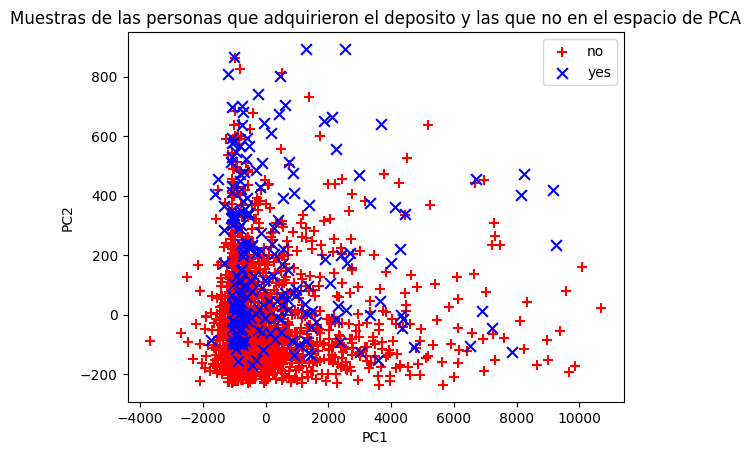

In [ ]:
colors = {'no':'r', 'yes':'b'}
markerTypes = {'no':'+', 'yes':'x'}

sample_subgroup_y = df_numerico.groupby("y").get_group(1).sample(frac=0.05)
sample_subgroup_n = df_numerico.groupby("y").get_group(0).sample(frac=0.05)
sample = pd.concat([sample_subgroup_y,sample_subgroup_n])


for bank in markerTypes:
    if bank ==  "no":
      d_sample = projected_numeric.loc[sample_subgroup_n.index, :]
      plt.scatter(d_sample['PC1'],d_sample['PC2'] ,c=colors[bank],s=60,marker=markerTypes[bank] , label=bank)

    else:
      d_sample = projected_numeric.loc[sample_subgroup_y.index, :]
      plt.scatter(d_sample['PC1'],d_sample['PC2'] ,c=colors[bank],s=60,marker=markerTypes[bank] , label=bank)


    plt.title("Muestras de las personas que adquirieron el deposito y las que no en el espacio de PCA")
    plt.legend()
    plt.xlabel("PC1")
    plt.ylabel("PC2")

Se observa que no hay mucha diferencia respecto al dataset limpio original, tras convertir el dataset a valores numéricos

##Discretización de las variables numéricas por simple binning (igual amplitud o labels)

Creación de un dataframe totalmente categorico por simple binning, para lo que necesitamos una copia del dataframe original.

In [ ]:
df_categorico = bank_df.copy()
df_categorico.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,194,0,failure,no
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,194,0,failure,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,194,0,failure,no
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,may,92,1,194,0,failure,no
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,may,198,1,194,0,failure,no


Variable balance discretizada en 5 bins: low, medium, normal, high y very high según su balance anual de ingresos.

In [ ]:
df_categorico['balance'] = pd.cut(x=df_categorico['balance'], bins=5,
                    labels=['low', 'medium', 'normal',
                            'hign', 'very high'])
print(df_categorico['balance'])
print(df_categorico['balance'].value_counts())

0        normal
1        normal
2        normal
3        normal
4        normal
          ...  
41085    normal
41086    normal
41087    normal
41088    normal
41089    normal
Name: balance, Length: 41090, dtype: category
Categories (5, object): ['low' < 'medium' < 'normal' < 'hign' < 'very high']
normal       35498
medium        2552
hign          2466
very high      572
low              2
Name: balance, dtype: int64


Variable age discretizada según el ciclo de vida, en 6 diferentes bins que son: Early childhood, childhood, adolescence, youth, adulthood y third age.

In [ ]:
df_categorico['age'] = pd.cut(x=df_categorico['age'], bins=[0,5,11,18,26,59,120],
                    labels=['Early childhood', 'childhood', 'Adolescence',
                            'Youth', 'Adulthood', 'Third age'])
print(df_categorico['age'])
print(df_categorico['age'].value_counts())


0        Adulthood
1        Adulthood
2        Adulthood
3        Adulthood
4        Adulthood
           ...    
41085        Youth
41086        Youth
41087    Adulthood
41088    Third age
41089    Adulthood
Name: age, Length: 41090, dtype: category
Categories (6, object): ['Early childhood' < 'childhood' < 'Adolescence' < 'Youth' < 'Adulthood' < 'Third age']
Adulthood          37878
Youth               1925
Third age           1276
Adolescence           11
Early childhood        0
childhood              0
Name: age, dtype: int64


Discretización de la variable duration en 5 bins: very short, short, half, long y extensive

In [ ]:
df_categorico['duration'] = pd.cut(x=df_categorico['duration'], bins=5,
                    labels=['very short', 'short', 'half',
                            'long', 'extensive'])
print(df_categorico['duration'])
print(df_categorico['duration'].value_counts())

0             short
1        very short
2        very short
3        very short
4        very short
            ...    
41085         short
41086         short
41087     extensive
41088         short
41089          half
Name: duration, Length: 41090, dtype: category
Categories (5, object): ['very short' < 'short' < 'half' < 'long' < 'extensive']
very short    25837
short         10407
half           3159
long           1251
extensive       436
Name: duration, dtype: int64


Discretización de la variable pdays en 3 bins: near, half y distant.

In [ ]:
df_categorico['pdays'] = pd.cut(x=df_categorico['pdays'], bins=3,
                    labels=['near', 'half', 'distant'])
print(df_categorico['pdays'])
print(df_categorico['pdays'].value_counts())

0        half
1        half
2        half
3        half
4        half
         ... 
41085    half
41086    half
41087    half
41088    half
41089    half
Name: pdays, Length: 41090, dtype: category
Categories (3, object): ['near' < 'half' < 'distant']
half       37329
distant     2236
near        1525
Name: pdays, dtype: int64


Discretización de la variable previous en 3 bins: rarely, half y many times.

In [ ]:
df_categorico['previous'] = pd.cut(x=df_categorico['previous'], bins=3,
                                    labels=['rarely', 'half', 'many times'])
print(df_categorico['previous'])
print(df_categorico['previous'].value_counts())

0        rarely
1        rarely
2        rarely
3        rarely
4        rarely
          ...  
41085    rarely
41086    rarely
41087    rarely
41088    rarely
41089    rarely
Name: previous, Length: 41090, dtype: category
Categories (3, object): ['rarely' < 'half' < 'many times']
rarely        38993
half           1830
many times      267
Name: previous, dtype: int64


Discretización de la variable campaign en 3 bins: rarely, half y many times

In [ ]:
df_categorico['campaign'] = pd.cut(x=df_categorico['campaign'], bins=3,
                    labels=['rarely', 'half', 'many times'])
print(df_categorico['campaign'])
print(df_categorico['campaign'].value_counts())

0        rarely
1        rarely
2        rarely
3        rarely
4        rarely
          ...  
41085    rarely
41086    rarely
41087    rarely
41088    rarely
41089    rarely
Name: campaign, Length: 41090, dtype: category
Categories (3, object): ['rarely' < 'half' < 'many times']
rarely        37830
half           2624
many times      636
Name: campaign, dtype: int64


Finalmente se muestra el dataset con todas las variables categoricas, discretizado por simple binning de igual amplitud y la edad por labels definidos según el ciclo de vida.

In [ ]:
df_categorico

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,Adulthood,management,married,tertiary,no,normal,yes,no,cellular,5,may,short,rarely,half,rarely,failure,no
1,Adulthood,technician,single,secondary,no,normal,yes,no,cellular,5,may,very short,rarely,half,rarely,failure,no
2,Adulthood,entrepreneur,married,secondary,no,normal,yes,yes,cellular,5,may,very short,rarely,half,rarely,failure,no
3,Adulthood,blue-collar,married,secondary,no,normal,yes,no,cellular,5,may,very short,rarely,half,rarely,failure,no
4,Adulthood,blue-collar,single,secondary,no,normal,no,no,cellular,5,may,very short,rarely,half,rarely,failure,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41085,Youth,student,single,tertiary,no,normal,no,no,cellular,17,nov,short,rarely,half,rarely,failure,yes
41086,Youth,technician,single,secondary,no,normal,no,yes,cellular,17,nov,short,rarely,half,rarely,failure,yes
41087,Adulthood,technician,married,tertiary,no,normal,no,no,cellular,17,nov,extensive,rarely,half,rarely,failure,yes
41088,Third age,retired,divorced,primary,no,normal,no,no,cellular,17,nov,short,rarely,half,rarely,failure,yes


In [ ]:
df_categorico.to_csv('/content/gdrive/Shareddrives/Minería de datos/Proyecto/I. Dataset/categorico.csv')

##Discretización por igual Frecuencia de las variables numéricas

Creamos una copia del dataset original

In [ ]:
df_categFrec = bank_df.copy()
df_categFrec.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,194,0,failure,no
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,194,0,failure,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,194,0,failure,no
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,may,92,1,194,0,failure,no
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,may,198,1,194,0,failure,no


Discretizamos la variable balance según sus quartiles

In [ ]:
df_categFrec['balance'] = pd.qcut(x=df_categFrec['balance'], q=4)


print(df_categFrec['balance'])
print(df_categFrec['balance'].value_counts())

0        (1331.0, 11766.0]
1        (-8019.001, 66.0]
2        (-8019.001, 66.0]
3        (1331.0, 11766.0]
4        (-8019.001, 66.0]
               ...        
41085        (66.0, 425.0]
41086      (425.0, 1331.0]
41087      (425.0, 1331.0]
41088    (1331.0, 11766.0]
41089      (425.0, 1331.0]
Name: balance, Length: 41090, dtype: category
Categories (4, interval[float64, right]): [(-8019.001, 66.0] < (66.0, 425.0] < (425.0, 1331.0] <
                                           (1331.0, 11766.0]]
(-8019.001, 66.0]    10308
(425.0, 1331.0]      10270
(1331.0, 11766.0]    10267
(66.0, 425.0]        10245
Name: balance, dtype: int64


Discretizamos la variable duration según sus quartiles

In [ ]:
df_categFrec['duration'] = pd.qcut(x=df_categFrec['duration'], q=4,
                    )
print(df_categFrec['duration'])
print(df_categFrec['duration'].value_counts())

0         (178.0, 306.0]
1         (104.0, 178.0]
2        (-0.001, 104.0]
3        (-0.001, 104.0]
4         (178.0, 306.0]
              ...       
41085     (178.0, 306.0]
41086    (306.0, 1156.0]
41087    (306.0, 1156.0]
41088    (306.0, 1156.0]
41089    (306.0, 1156.0]
Name: duration, Length: 41090, dtype: category
Categories (4, interval[float64, right]): [(-0.001, 104.0] < (104.0, 178.0] < (178.0, 306.0] <
                                           (306.0, 1156.0]]
(-0.001, 104.0]    10436
(306.0, 1156.0]    10222
(104.0, 178.0]     10221
(178.0, 306.0]     10211
Name: duration, dtype: int64


Discretizamos la variable age según sus quartiles

In [ ]:
df_categFrec['age'] = pd.qcut(x=df_categFrec['age'], q=4,
                    )
print(df_categFrec['age'])
print(df_categFrec['age'].value_counts())

0          (48.0, 78.0]
1          (39.0, 48.0]
2        (17.999, 33.0]
3          (39.0, 48.0]
4        (17.999, 33.0]
              ...      
41085    (17.999, 33.0]
41086    (17.999, 33.0]
41087      (48.0, 78.0]
41088      (48.0, 78.0]
41089      (48.0, 78.0]
Name: age, Length: 41090, dtype: category
Categories (4, interval[float64, right]): [(17.999, 33.0] < (33.0, 39.0] < (39.0, 48.0] <
                                           (48.0, 78.0]]
(17.999, 33.0]    11951
(39.0, 48.0]       9856
(48.0, 78.0]       9836
(33.0, 39.0]       9447
Name: age, dtype: int64


Discretizamos la variable previous según sus quartiles

In [ ]:
df_categFrec['previous'] = pd.qcut(x=df_categFrec['previous'], q=4, duplicates='drop'
                    )
print(df_categFrec['previous'])
print(df_categFrec['previous'].value_counts())

0        (-0.001, 8.0]
1        (-0.001, 8.0]
2        (-0.001, 8.0]
3        (-0.001, 8.0]
4        (-0.001, 8.0]
             ...      
41085    (-0.001, 8.0]
41086    (-0.001, 8.0]
41087    (-0.001, 8.0]
41088    (-0.001, 8.0]
41089    (-0.001, 8.0]
Name: previous, Length: 41090, dtype: category
Categories (1, interval[float64, right]): [(-0.001, 8.0]]
(-0.001, 8.0]    41090
Name: previous, dtype: int64


Discretizamos la variable campaign según sus quartiles

In [ ]:
df_categFrec['campaign'] = pd.qcut(x=df_categFrec['campaign'], q=4,duplicates='drop'
                    )
print(df_categFrec['campaign'])
print(df_categFrec['campaign'].value_counts())

0        (0.999, 2.0]
1        (0.999, 2.0]
2        (0.999, 2.0]
3        (0.999, 2.0]
4        (0.999, 2.0]
             ...     
41085    (0.999, 2.0]
41086    (0.999, 2.0]
41087      (2.0, 3.0]
41088    (0.999, 2.0]
41089     (3.0, 13.0]
Name: campaign, Length: 41090, dtype: category
Categories (3, interval[float64, right]): [(0.999, 2.0] < (2.0, 3.0] < (3.0, 13.0]]
(0.999, 2.0]    27848
(3.0, 13.0]      8157
(2.0, 3.0]       5085
Name: campaign, dtype: int64


Discretizamos la variable pdays según sus quartiles

In [ ]:
df_categFrec['pdays'] = pd.qcut(x=df_categFrec['pdays'], q=4, duplicates = 'drop'
                    )
print(df_categFrec['pdays'])
print(df_categFrec['pdays'].value_counts())

0        (29.999, 194.0]
1        (29.999, 194.0]
2        (29.999, 194.0]
3        (29.999, 194.0]
4        (29.999, 194.0]
              ...       
41085    (29.999, 194.0]
41086    (29.999, 194.0]
41087    (29.999, 194.0]
41088    (29.999, 194.0]
41089    (29.999, 194.0]
Name: pdays, Length: 41090, dtype: category
Categories (2, interval[float64, right]): [(29.999, 194.0] < (194.0, 374.0]]
(29.999, 194.0]    38080
(194.0, 374.0]      3010
Name: pdays, dtype: int64


In [ ]:
bank_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

Finalmente tenemos el dataset discretizado por igual Frecuencia según los quartiles:

In [ ]:
df_categFrec

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,"(48.0, 78.0]",management,married,tertiary,no,"(1331.0, 11766.0]",yes,no,cellular,5,may,"(178.0, 306.0]","(0.999, 2.0]","(29.999, 194.0]","(-0.001, 8.0]",failure,no
1,"(39.0, 48.0]",technician,single,secondary,no,"(-8019.001, 66.0]",yes,no,cellular,5,may,"(104.0, 178.0]","(0.999, 2.0]","(29.999, 194.0]","(-0.001, 8.0]",failure,no
2,"(17.999, 33.0]",entrepreneur,married,secondary,no,"(-8019.001, 66.0]",yes,yes,cellular,5,may,"(-0.001, 104.0]","(0.999, 2.0]","(29.999, 194.0]","(-0.001, 8.0]",failure,no
3,"(39.0, 48.0]",blue-collar,married,secondary,no,"(1331.0, 11766.0]",yes,no,cellular,5,may,"(-0.001, 104.0]","(0.999, 2.0]","(29.999, 194.0]","(-0.001, 8.0]",failure,no
4,"(17.999, 33.0]",blue-collar,single,secondary,no,"(-8019.001, 66.0]",no,no,cellular,5,may,"(178.0, 306.0]","(0.999, 2.0]","(29.999, 194.0]","(-0.001, 8.0]",failure,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41085,"(17.999, 33.0]",student,single,tertiary,no,"(66.0, 425.0]",no,no,cellular,17,nov,"(178.0, 306.0]","(0.999, 2.0]","(29.999, 194.0]","(-0.001, 8.0]",failure,yes
41086,"(17.999, 33.0]",technician,single,secondary,no,"(425.0, 1331.0]",no,yes,cellular,17,nov,"(306.0, 1156.0]","(0.999, 2.0]","(29.999, 194.0]","(-0.001, 8.0]",failure,yes
41087,"(48.0, 78.0]",technician,married,tertiary,no,"(425.0, 1331.0]",no,no,cellular,17,nov,"(306.0, 1156.0]","(2.0, 3.0]","(29.999, 194.0]","(-0.001, 8.0]",failure,yes
41088,"(48.0, 78.0]",retired,divorced,primary,no,"(1331.0, 11766.0]",no,no,cellular,17,nov,"(306.0, 1156.0]","(0.999, 2.0]","(29.999, 194.0]","(-0.001, 8.0]",failure,yes


In [ ]:
df_categFrec.to_csv('/content/gdrive/Shareddrives/Minería de datos/Proyecto/I. Dataset/categoricoFrecuencia.csv')

##Discretización por clusters (kmeans) usando sklearn

Para hacer la discretización de el dataset por clusterización, usamos la estrategia Kmeans aplicada en la función KBinsDiscretizer.

Primero creamos una copia del dataset:

In [ ]:
df_categKM = bank_df.copy()
df_categKM.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,194,0,failure,no
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,194,0,failure,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,194,0,failure,no
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,may,92,1,194,0,failure,no
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,may,198,1,194,0,failure,no


Creamos un estimador usando KBinsDiscretizer para luego entrenarlo con la función .fit() y hacer la respectiva transformación en el dataset del atributo balance.

In [ ]:
est = KBinsDiscretizer(
       n_bins=5, encode='ordinal', strategy='kmeans', subsample=None)
est.fit(df_categKM[['balance']])
df_categKM['balance'] = est.transform(df_categKM[['balance']])

Creamos un estimador usando KBinsDiscretizer para luego entrenarlo con la función .fit() y hacer la respectiva transformación en el dataset del atributo age.

In [ ]:
est = KBinsDiscretizer(
       n_bins=5, encode='ordinal', strategy='kmeans', subsample=None)
est.fit(df_categKM[['age']])
df_categKM['age'] = est.transform(df_categKM[['age']])

Creamos un estimador usando KBinsDiscretizer para luego entrenarlo con la función .fit() y hacer la respectiva transformación en el dataset del atributo previous.

In [ ]:
est = KBinsDiscretizer(
       n_bins=5, encode='ordinal', strategy='kmeans', subsample=None)
est.fit(df_categKM[['previous']])
df_categKM['previous'] = est.transform(df_categKM[['previous']])

Creamos un estimador usando KBinsDiscretizer para luego entrenarlo con la función .fit() y hacer la respectiva transformación en el dataset del atributo pdays.

In [ ]:
est = KBinsDiscretizer(
       n_bins=5, encode='ordinal', strategy='kmeans', subsample=None)
est.fit(df_categKM[['pdays']])
df_categKM['pdays'] = est.transform(df_categKM[['pdays']])

Creamos un estimador usando KBinsDiscretizer para luego entrenarlo con la función .fit() y hacer la respectiva transformación en el dataset del atributo campaign.

In [ ]:
est = KBinsDiscretizer(
       n_bins=5, encode='ordinal', strategy='kmeans', subsample=None)
est.fit(df_categKM[['campaign']])
df_categKM['campaign'] = est.transform(df_categKM[['campaign']])

Creamos un estimador usando KBinsDiscretizer para luego entrenarlo con la función .fit() y hacer la respectiva transformación en el dataset del atributo duration.

In [ ]:
est = KBinsDiscretizer(
       n_bins=5, encode='ordinal', strategy='kmeans', subsample=None)
est.fit(df_categKM[['duration']])
df_categKM['duration'] = est.transform(df_categKM[['duration']])

Finalmente tenemos un dataset discretizado por clusterización aplicado a las variables numéricas:

In [ ]:
df_categKM

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,3.0,management,married,tertiary,no,2.0,yes,no,cellular,5,may,1.0,0.0,2.0,0.0,failure,no
1,2.0,technician,single,secondary,no,1.0,yes,no,cellular,5,may,1.0,0.0,2.0,0.0,failure,no
2,1.0,entrepreneur,married,secondary,no,1.0,yes,yes,cellular,5,may,0.0,0.0,2.0,0.0,failure,no
3,2.0,blue-collar,married,secondary,no,2.0,yes,no,cellular,5,may,0.0,0.0,2.0,0.0,failure,no
4,1.0,blue-collar,single,secondary,no,1.0,no,no,cellular,5,may,1.0,0.0,2.0,0.0,failure,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41085,0.0,student,single,tertiary,no,1.0,no,no,cellular,17,nov,1.0,0.0,2.0,0.0,failure,yes
41086,0.0,technician,single,secondary,no,1.0,no,yes,cellular,17,nov,2.0,0.0,2.0,0.0,failure,yes
41087,2.0,technician,married,tertiary,no,1.0,no,no,cellular,17,nov,4.0,1.0,2.0,0.0,failure,yes
41088,4.0,retired,divorced,primary,no,2.0,no,no,cellular,17,nov,2.0,0.0,2.0,0.0,failure,yes


In [ ]:
df_categKM.to_csv('/content/gdrive/Shareddrives/Minería de datos/Proyecto/I. Dataset/categoricoKMeans.csv')

## Ranking según medias y varianzas


Implementamos un metodo que realiza el ranking de forma automatizada. Aplicaremos este metodo sobre el dataset numerico.

En nuestro metodo automatizado para cada atributo calculamos los valores de los registros que respondieron si y no.

Luego calcula el valor de SE para cada una de las variables siguiendo la formula

$$SE(V_{no} - V_{yes}) = \sqrt{var(V_{no})/n_{no} + var(V_{yes})/n_{yes}}$$


Y finalmente se aplica el test para cada variable

$$|mean(V_{no}) - mean(V_{yes})|/SE(V_{no} - V_{yes})$$

Luego de que se calculan los test para cada variable se imprime el ranking, donde las variables estan organizadas de mayor valor en el test a menor valor en el test.

In [ ]:
def ranking_medias_y_varianzas(df, columna_clase):
  diccionario_test = dict()

  for column in df:
    if column != columna_clase:
      #Arreglo de datos de la columna de personas que no aceptaron el deposito
      column_no = np.array(df[df.y == 0][column])
      #Arreglo de datos de la columna de personas que si aceptaron el deposito
      column_yes = np.array(df[df.y == 1][column])

      #Calcular el valor SE para la columna
      SE_column = math.sqrt( (column_no.var()/len(column_no)) + (column_yes.var()/len(column_yes)) )

      #Calcular el valor del test para cada columna
      test_column= abs(column_no.mean() - column_yes.mean())/SE_column

      diccionario_test[column] = test_column

  #Se imprime el diccionario en orden
  ranking_test = dict(sorted(diccionario_test.items(), key=lambda item: item[1], reverse = True))

  print("Las variables mas abajo del ranking pueden ser retiradas")
  print("El ranking obtenido es el siguiente: ")
  for column in ranking_test:
    print("Valor test para la variable "+column+" :"+str(ranking_test[column]))

ranking_medias_y_varianzas(df_numerico, "y")

Las variables mas abajo del ranking pueden ser retiradas
El ranking obtenido es el siguiente: 
Valor test para la variable duration :56.495568058202785
Valor test para la variable housing :30.62609103953483
Valor test para la variable success :27.488807715316142
Valor test para la variable failure :27.29395410499165
Valor test para la variable campaign :21.534764843299094
Valor test para la variable previous :20.07569485365823
Valor test para la variable pdays :19.23775383949927
Valor test para la variable loan :16.550774086036323
Valor test para la variable education :16.08249206481414
Valor test para la variable blue-collar :15.616279410444319
Valor test para la variable single :12.831863270647352
Valor test para la variable balance :12.526853703344427
Valor test para la variable married :12.041064929473684
Valor test para la variable student :10.776674664629574
Valor test para la variable retired :8.848391312682962
Valor test para la variable management :6.271513782804175
Valor test

Se observa que las variables admin, technician, divorced, self-employed y age son las 5 que se podrian retirar del dataset ya que son las que menos permiten distinguir entre las dos clases.

## Ranking según entropía

In [ ]:
def build_similarity_matrix(df):
  similarity_matrix = np.zeros(tuple([df.shape[0], df.shape[0]]))
  for i in range(similarity_matrix.shape[0]):
    for j in range(i,similarity_matrix.shape[0]):
      similarity_matrix[i][j] = (np.array(df.loc[i,]) == np.array(df.loc[j,])).sum() / (df.shape[1])
  return similarity_matrix

def entropy(df):
  E_total = 0
  similarity_matrix = build_similarity_matrix(df)
  for i in range(similarity_matrix.shape[0] - 1):
    for j in range(i+1,similarity_matrix.shape[0]):
      element = similarity_matrix[i][j]
      if (element != 0) and (element != 1.0):
        E_total = E_total + ((element*math.log(element,2))+((1-element)*math.log(1-element,2)))

  E_total = E_total * -1
  return E_total

def ranking(df):
  ranking = []
  df_copy = df.copy()
  while df_copy.shape[1] > 1:
    subset_entropy = entropy(df_copy)
    without_column_entropies = {}
    for column in df_copy:
      without_column_entropies[column] = entropy(df_copy.drop(labels=column, axis = 1))

    min_diff = np.inf
    min_columns = []
    for column, entropy_value in  without_column_entropies.items():
      if np.isclose(subset_entropy - entropy_value, min_diff):
        min_columns.append(column)
      elif subset_entropy - entropy_value < min_diff:
        min_diff = subset_entropy - entropy_value
        min_columns = [column]

    selected_column_for_drop = np.random.choice(np.array(min_columns),1)[0]
    ranking.insert(0,selected_column_for_drop)
    df_copy = df_copy.drop(labels=selected_column_for_drop , axis=1)

  ranking.insert(0, df_copy.columns[0])
  # Retorna el ranking, donde la última dimensión es la que se recomienda eliminar en primer lugar
  return ranking

Ranking de entropía calculada sobre muestra de dataframe categorico por igual amplitud y etiquetas

In [ ]:
df_categ_sample_yes = df_categorico.groupby("y").get_group("yes").sample(frac=0.001)
df_categ_sample_no = df_categorico.groupby("y").get_group("no").sample(frac=0.001)
df_categ_sample = pd.concat([df_categ_sample_yes,df_categ_sample_no])
df_categ_sample = df_categ_sample.drop(columns=["y"],)
df_categ_sample = df_categ_sample.reset_index(drop=True)

print(ranking(df_categ_sample))

['day', 'default', 'contact', 'job', 'balance', 'month', 'age', 'duration', 'education', 'housing', 'marital', 'campaign', 'loan', 'pdays', 'previous', 'poutcome']


Ranking de entropía calculada sobre muestra de dataframe categorico por misma frecuencia


In [ ]:
df_categFrec_sample_yes = df_categFrec.groupby("y").get_group("yes").sample(frac=0.001)
df_categFrec_sample_no = df_categFrec.groupby("y").get_group("no").sample(frac=0.001)
df_categFrec_sample = pd.concat([df_categFrec_sample_yes,df_categFrec_sample_no])
df_categFrec_sample = df_categFrec_sample.drop(columns=["y"],)
df_categFrec_sample = df_categFrec_sample.reset_index(drop=True)

print(ranking(df_categFrec_sample))

['previous', 'day', 'job', 'default', 'month', 'contact', 'duration', 'loan', 'age', 'balance', 'pdays', 'marital', 'campaign', 'education', 'housing', 'poutcome']


Ranking de entropía calculada sobre muestra de dataframe categorico por k-means

In [ ]:
df_categKM_sample_yes = df_categKM.groupby("y").get_group("yes").sample(frac=0.001)
df_categKM_sample_no = df_categKM.groupby("y").get_group("no").sample(frac=0.001)
df_categKM_sample = pd.concat([df_categKM_sample_yes,df_categKM_sample_no])
df_categKM_sample = df_categKM_sample.drop(columns=["y"],)
df_categKM_sample = df_categKM_sample.reset_index(drop=True)

print(ranking(df_categKM_sample))

['default', 'day', 'month', 'contact', 'job', 'poutcome', 'duration', 'loan', 'age', 'balance', 'previous', 'campaign', 'education', 'housing', 'marital', 'pdays']
